In [1]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('div.output_stderr').hide();
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('div.output_stderr').show();
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')


# Predicting Homicides in Chicago 

The increase in homicide rates over the past few years, particularly in Chicago, has become a matter of interest and concern around the country. Efforts to understand the underlying causes of the increase are being executed from many angles. 

I will use data from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system to investigate the differences between homicides and other crimes committed in Chicago between the years 2005 and 2016. The data includes information on type, time, and location for each crime. I will then build a model to predict if a crime is a homicide.

In [2]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chisquare
RANDOM_STATE = 0

## Data Cleaning and Preprocessing

The data sets provided by the Chicago Police were very large, so I decided to sample a random 25% of the data in order to increase the speed of the analyses. However, homicides account for such a small percentage of the total crimes, I decided to go through and selectively sample every homicide in the data set in order to get as much information about those crimes as possible. 

The date and time information for each crime was originally located in a single column as a string object. In order to examine the temporal data about the crimes more easily, I converted the column to datetime format and added new columns for each of month, day of week, and hour of crime. 

Next, I was interested to see if homicides were more likely to occur in certain locations compared to other crimes. In order to do so, I created dummy variable columns for each of the top five location categories where the most homicides occurred. I also created a dummy variable column 'other' that represented all other location categories.  

Finally, I created a column for use in future analyses that labeled each crime as either 1 for homicide or 0 for not homicide. 

Once the data was cleaned, I decided to further address the issue of the imbalance in the data. I used the following samples for the analyses.

* **Original sampling:** I selectively sampled every homicide and only a random 25% of all other crimes. Homicides accounted for <1% of the data in this sample. I used this sample for all exploratory data analyses.


* **Under-sampling:** I used the RandomUnderSampler algorithm to randomly under-sample the majority class (not-homicide). The algorithm randomly selected samples from the majority class until it had an equal number of samples as the minority class (homicide).


* **Over-sampling:** I used the Synthetic Minority Oversampling Technique (SMOTE) to create synthetic minority class (homicide) members until the minority class had a similar number of samples as the majority class (not-homicide).

In [22]:
#list of csv files from the CPD's CLEAR system
csvs = ['Chicago_Crimes_2005_to_2007.csv', 'Chicago_Crimes_2008_to_2011.csv',
        'Chicago_Crimes_2012_to_2017.csv']

random.seed(a=0)

#create an empty data frame
cc = pd.DataFrame()

#for each csv file, randomly select 25% of data, then select every homicide
#combine all data into a single dataframe named cc
for x in csvs:
    #randomly select 25% of crimes and read into a dataframe
    num_lines = sum(1 for l in open(x))
    size = int(num_lines / 4)
    skip_idx = random.sample(range(1, num_lines), num_lines - size)
    ccr = pd.read_csv(x, skiprows=skip_idx, error_bad_lines=False,warn_bad_lines=False)
    #select each homicide and read into a dataframe
    iter_csv = pd.read_csv(x, iterator=True, chunksize=500, error_bad_lines=False,warn_bad_lines=False)
    cch = pd.concat(chunk[chunk['Primary Type'] == 'HOMICIDE'] for chunk in iter_csv)
    #combine dataframes
    cc = pd.concat([cc, ccr, cch])

del ccr, cch

#drop the crimes from 2017 because the data is incomplete    
cc = cc[cc['Year']<2017]

In [4]:
#hide error message
pd.options.mode.chained_assignment = None

#drop extraneous columns
cc = cc.drop(['ID', 'Case Number', 'Updated On', 'Location'], 1)

#drop null values
cc = cc.dropna()

#rename columns for easier reference
cc = cc.rename(index=str, columns={'Date':'date','Block':'block','IUCR':'iucr',
                                   'Primary Type':'primary_type', 'Description':'description',
                                   'Location Description':'location_description',
                                   'Arrest':'arrest', 'Domestic': 'domestic', 'Beat': 'beat',
                                   'District':'district', 'Ward':'ward',
                                   'Community Area':'community_area', 'FBI Code':'fbi_code',
                                   'X Coordinate':'x_coord','Y Coordinate':'y_coord',
                                   'Year':'year', 'Latitude':'latitude',
                                   'Longitude':'longitude'})

#add a column location_category that labels the crime locations as 
#ORIGINAL - STREET, AUTO, APARTMENT, RESIDENCE, SIDEWALK, or OTHER.
#STREET, AUTO, APARTMENT, ALLEY, HOUSE, OR OTHER
cc.loc[:,'location_category']=cc['location_description']

cc.loc[:,'location_category'][(cc['location_description'] != 'STREET')&\
                             (cc['location_description'] != 'AUTO') &  \
                           (cc['location_description'] != 'APARTMENT') &\
                              (cc['location_description'] != 'ALLEY') &\
                            (cc['location_description'] != 'HOUSE')] ="OTHERS"

#convert location category to dummy varaible columns
df2 = pd.get_dummies(cc.location_category).astype(int)

cc['street'] = df2['STREET']
cc['auto'] = df2['AUTO']
cc['apartment'] = df2['APARTMENT']
cc['alley'] = df2['ALLEY']
cc['house'] = df2['HOUSE']
cc['others'] = df2['OTHERS']

#convert the date column into datetime type
cc['date'] = pd.to_datetime(cc.date, format="%m/%d/%Y %I:%M:%S %p")

#add columns for month, day of week, and hours
cc.loc[:,'month']=cc['date'].dt.month
cc.loc[:,'day_of_week']=cc['date'].dt.dayofweek
cc.loc[:,'hour']=cc['date'].dt.hour

#add a column that categorizes all crimes as homicide = 1 or not = 0
cc['homicide'] = (cc['primary_type']=='HOMICIDE').astype(int)

## Exploratory Data Analysis



### Yearly variation

I first wanted to look at the total number of homicides per year as compared to the total number of crimes per year to see if they were changing similarly over time.


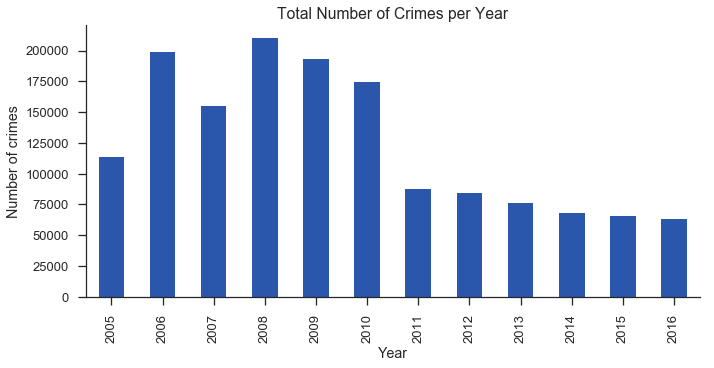

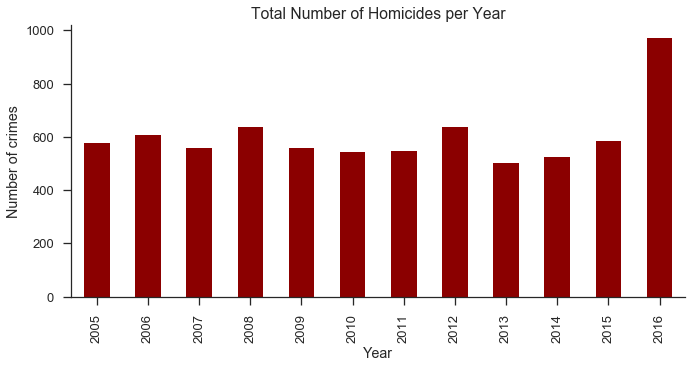

In [5]:
#plot number of crimes per year

sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context('talk')
# Update the matplotlib configuration parameters:
#matplotlib.rcParams.update({'font.size': 18})

sns.plt.figure(figsize=(11,5))
cc.groupby(['year']).size().plot.bar(color='#2a57ab')
sns.despine()
plt.title('Total Number of Crimes per Year')
plt.xlabel('Year')
plt.ylabel('Number of crimes')
plt.show()
#sns.despine()

#plot total number of homicides per year
plt.figure(figsize=(11,5))
cc[cc.primary_type == 'HOMICIDE'].groupby(['year']).size().plot.bar(color = 'DarkRed')
sns.despine()
plt.title('Total Number of Homicides per Year')
plt.xlabel('Year')
plt.ylabel('Number of crimes')
plt.show()

It is easy to see that these distributions look very different. The total number of homicides per year appears to remain relatively consistent until it experiences an increase in 2016. This is consistent with reports of a significant increase in the homicide rate. However, the total number of crimes looks very different over time. After a peak in 2008, you can see a significant drop off that continues through 2016. It is also worth noting that the number of homicides is less than 1% of all the reports. 

###  Monthly variation 

Next, I wanted to see investigate how the number of crimes and homicides changes throughout the course of a year. I first plotted the total number of crimes and homicides per month.

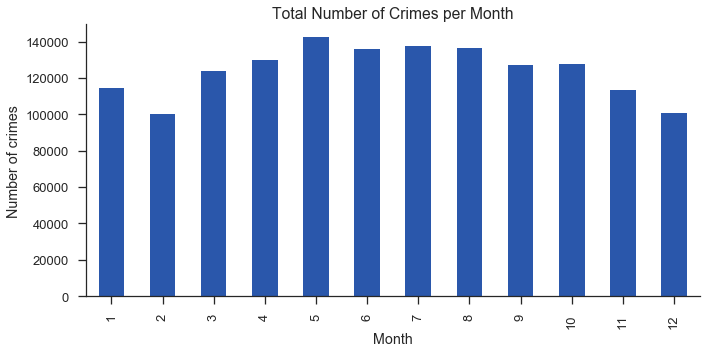

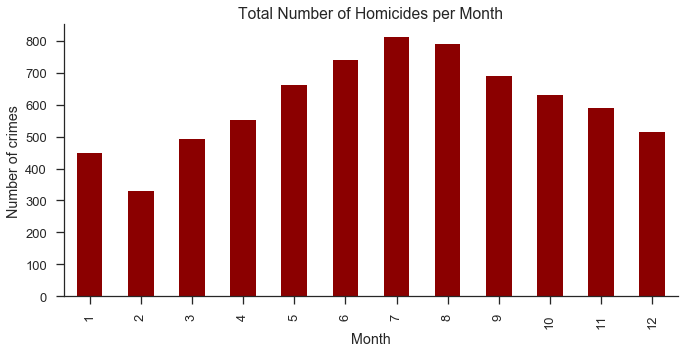

In [7]:
#plot number of crimes per month

sns.set_context('talk')
plt.figure(figsize=(11,5))
cc.groupby(['month']).size().plot.bar(color='#2a57ab')
sns.despine()
plt.title('Total Number of Crimes per Month')
plt.xlabel('Month')
plt.ylabel('Number of crimes')
plt.show()

#plot total number of homicides per month
plt.figure(figsize=(11,5))
cc[cc.primary_type == 'HOMICIDE'].groupby(['month']).size().plot.bar(color = 'DarkRed')
sns.despine()
plt.title('Total Number of Homicides per Month')
plt.xlabel('Month')
plt.ylabel('Number of crimes')
plt.show()

Next, in order to get a better sense of how consistent the monthly number of crimes are year to year, I created box plots of the average number of crimes and homicides per month between 2005 and 2016.

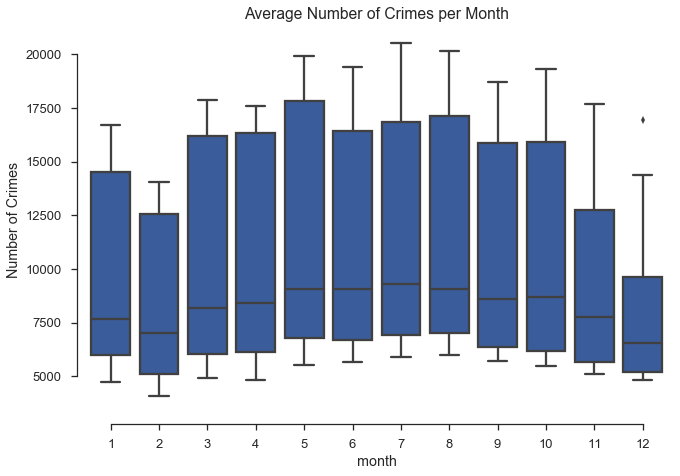

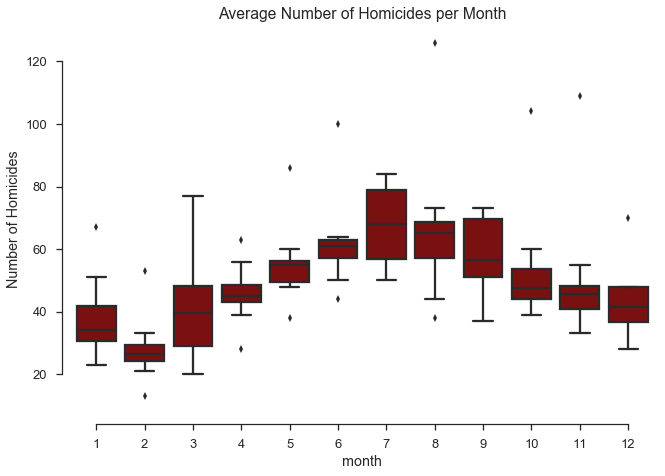

In [8]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
          'September', 'October','November', 'December']

dfr = cc.groupby(['month', 'year']).size()
dfr = pd.DataFrame(dfr)
dfr = dfr.unstack()

dfh = cc[cc.homicide == 1].groupby(['month', 'year']).size()
dfh = pd.DataFrame(dfh)
dfh = dfh.unstack()

sns.set(style="ticks")
sns.set_context('talk')

sns.boxplot(data=dfr.T, color='#2a57ab')
sns.despine(offset=10, trim=True)
sns.plt.title('Average Number of Crimes per Month')
sns.plt.ylabel('Number of Crimes')

plt.figure()
sns.boxplot(data=dfh.T, color='DarkRed')
sns.despine(offset=10, trim=True)
sns.plt.title('Average Number of Homicides per Month')
sns.plt.ylabel('Number of Homicides')


Homicide rates have a much greater monthly variation compared to all crimes, with homicides more likely to occur in the summer months. However, there is much less year to year variation in monthly homicide rates as compared to all crimes. This is a good indication that the monthly variation is significant factor that affect the homicide rates.  

### Weekly variation

Next, I wanted to see if there were similar variations in homicide rates throughout the week.

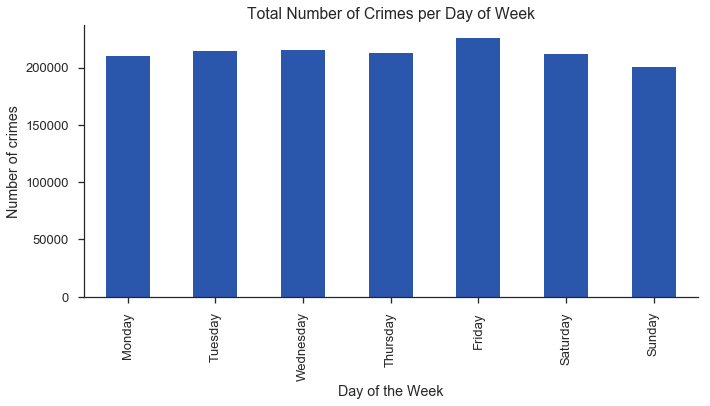

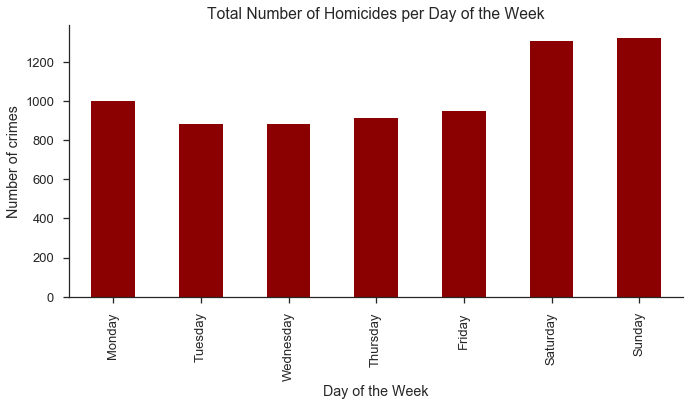

In [9]:
days = ['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#plot number of crimes per day of week
sns.set_context('talk')
plt.figure(figsize=(11,5))
cc.groupby(['day_of_week']).size().plot.bar(color = '#2a57ab')
sns.despine()
plt.title('Total Number of Crimes per Day of Week')
plt.xlabel('Day of the Week')
plt.xticks(np.arange(7), days)
plt.ylabel('Number of crimes')
plt.show()

#plot total number of homicides per day of week
plt.figure(figsize=(11,5))
cc[cc.primary_type == 'HOMICIDE'].groupby(['day_of_week']).size().plot.bar(color = 'DarkRed')
sns.despine()
plt.title('Total Number of Homicides per Day of the Week')
plt.xlabel('Day of the Week')
plt.xticks(np.arange(7), days)
plt.ylabel('Number of crimes')
plt.show()

([<matplotlib.axis.XTick at 0x10f607518>,
 <a list of 7 Text xticklabel objects>)

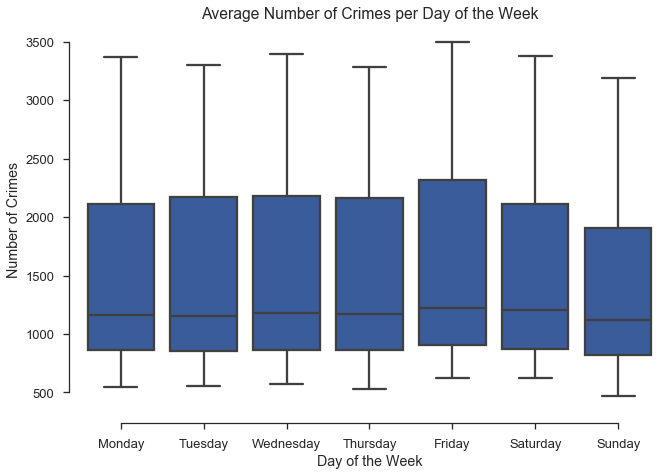

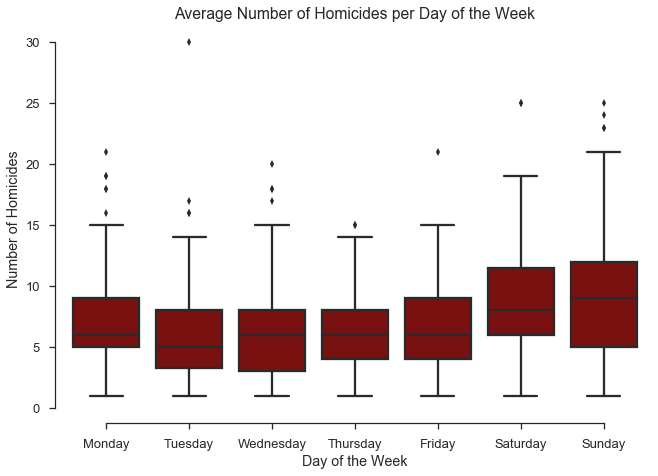

In [10]:
days = ['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

dfdw = cc.groupby(['day_of_week','month', 'year']).size()
dfdw = pd.DataFrame(dfdw)
dfdw = dfdw.unstack()
dfdw = dfdw.unstack()

dfdwh = cc[cc.homicide==1].groupby(['day_of_week','month', 'year']).size()
dfdwh = pd.DataFrame(dfdwh)
dfdwh = dfdwh.unstack()
dfdwh = dfdwh.unstack()

sns.set(style="ticks")
sns.set_context('talk')

sns.boxplot(data=dfdw.T, color = '#2a57ab')
sns.despine(offset=10, trim=True)
sns.plt.title('Average Number of Crimes per Day of the Week')
sns.plt.ylabel('Number of Crimes')
sns.plt.xlabel('Day of the Week')
sns.plt.xticks(np.arange(7), days)

plt.figure()
sns.boxplot(data=dfdwh.T, color = 'DarkRed')
sns.despine(offset=10, trim=True)
sns.plt.title('Average Number of Homicides per Day of the Week')
sns.plt.ylabel('Number of Homicides')
sns.plt.xlabel('Day of the Week')
sns.plt.xticks(np.arange(7), days)

While there isn't much variation in overall crime rates throughout the week, homicides are more likely to occur on the weekends.

### Daily variation.

Next, let's look at the time of day.

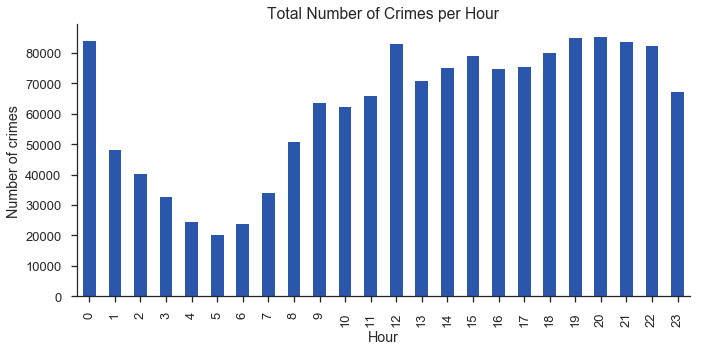

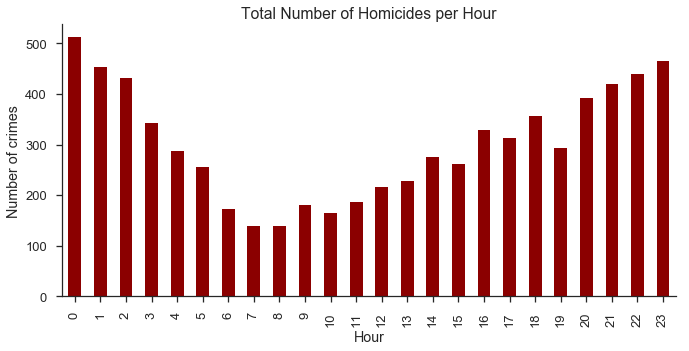

In [11]:
#plot number of crimes per hour
sns.set_context('talk')
plt.figure(figsize=(11,5))
cc.groupby(cc.hour).size().plot.bar(color='#2a57ab')
sns.despine()
plt.title('Total Number of Crimes per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of crimes')
plt.show()

#plot number of homicides per hour
plt.figure(figsize=(11,5))
hom = cc[cc.homicide ==1]
hom.groupby(hom.hour).size().plot.bar(color = 'DarkRed')
sns.despine()
plt.title('Total Number of Homicides per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of crimes')
plt.show()

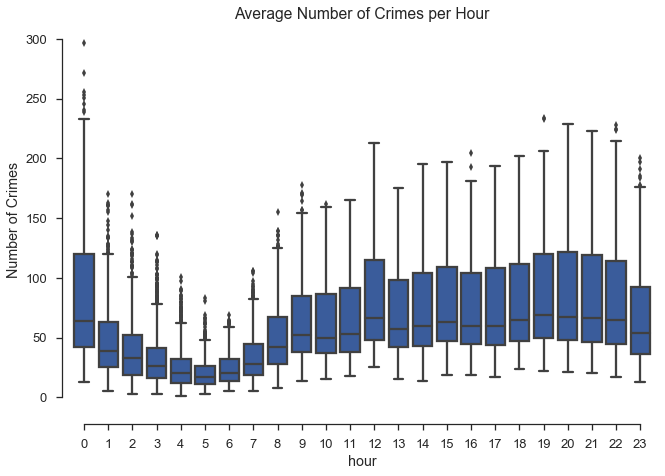

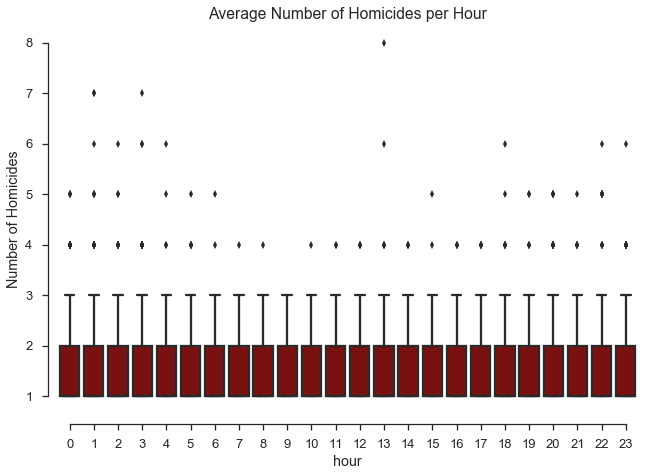

In [12]:
dfhour = cc.groupby(['hour','day_of_week','month', 'year']).size()
dfhour = pd.DataFrame(dfhour)
dfhour = dfhour.unstack().unstack()
dfhour = dfhour.unstack()

dfhourh = cc[cc.homicide==1].groupby(['hour','day_of_week','month', 'year']).size()
dfhourh = pd.DataFrame(dfhourh)
dfhourh = dfhourh.unstack().unstack()
dfhourh = dfhourh.unstack()

sns.set(style="ticks")
sns.set_context('talk')

sns.boxplot(data=dfhour.T, color='#2a57ab')
sns.despine(offset=10, trim=True)
sns.plt.title('Average Number of Crimes per Hour')
sns.plt.ylabel('Number of Crimes')

plt.figure()
sns.boxplot(data=dfhourh.T, color='DarkRed')
sns.despine(offset=10, trim=True)
sns.plt.title('Average Number of Homicides per Hour')
sns.plt.ylabel('Number of Homicides')

### Location

Next, I wanted to see if there were any places where homicides were disproportionately likely to occur.

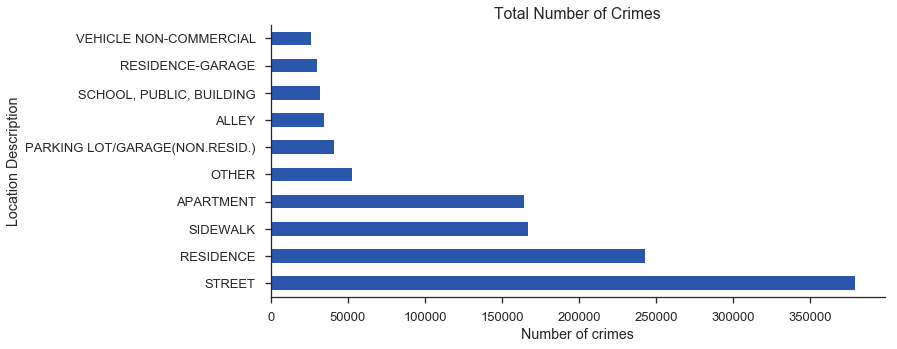

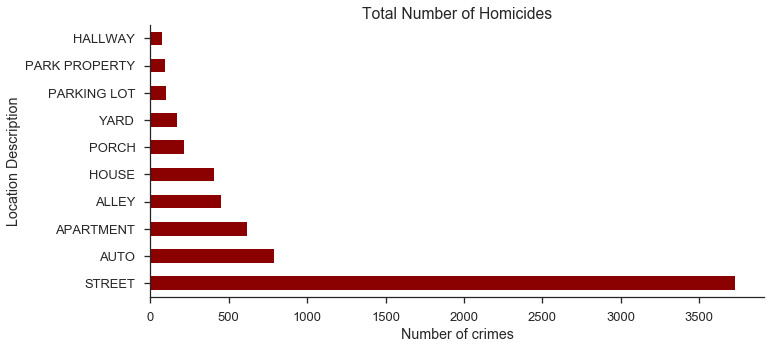

In [13]:
#plot number of crimes in top 10 most common locations
plt.figure(figsize=(11,5))
cc.groupby(cc.location_description).size().sort_values(ascending=False).head(10).plot.barh(
    color='#2a57ab')
sns.despine()
plt.title('Total Number of Crimes')
plt.ylabel('Location Description')
plt.xlabel('Number of crimes')
plt.show()

#plot number of homicides per hour
plt.figure(figsize=(11,5))
cc[cc.primary_type == 'HOMICIDE'].groupby(['location_description']).size().sort_values(
    ascending = False).head(10).plot.barh(color = 'DarkRed')
sns.despine()
plt.title('Total Number of Homicides')
plt.ylabel('Location Description')
plt.xlabel('Number of crimes')
plt.show()

While the street is the most common location description for both homicides and all crimes, the only other location that is in the top five for both is "apartment." 

# Models

Next, the goal is to build a model to predict if a crime will be a homicide by only knowing information about the time and location of the crime. Homicides make up less than 1% of the total crimes in the data set, which means that the classes of the target variable are severely unbalanced. In order to address this issue and prevent the classifier from simply labeling everything as not-homicide, I decided to balance the data of the training set. See the wrangling section for details.

Due to the imbalance in the data set, standard metrics, such as overall accuracy, would remain high even if the model simply classified every crime as 'not-homicide.' In order to avoid that problem and be able to focus on finding all of the homicides, I chose to try two different performance metrics: recall (which represents the accuracy of homicide classifications) and f1 score.

### Decision Tree classifier
I decided to try a simple Decision Tree classifier. The decision tree has a few key advantages:

1. Decision trees work well with imbalanced data sets because each class is considered when making each split.
2. The results are easy to interpret and thus easy to learn from. 
3. The reliability/validity of the model can be measured with statistical tests.

However, decision trees also have some disadvantages:

1. They are susceptible to overfitting, or creating trees that are too complex and thus don't generalize well.
2. They can be unstable, meaning a slightly different set of data can produce a completely different tree.
3. Even though decision trees are forced to consider each class at each decision point, they can still produce biased trees if there is a dominant class. 
4. Due to the structure of the algorithm, it is not guaranteed to produce a tree that is holistically optimal. Instead, decisions at each node are made independently and individually without consideration for the optimal solution for the tree as a whole. 

### Random Forest Classifier.
In order to address some of the limitations of the decision tree classifier, I also decided to use a random forest classifier. This is an ensemble method that trains multiple decision tree classifiers from a bootstrap sample and then averages the results to produce a model that has less variance than a single decision tree. The random forest has many of the same advantages as the decision tree, but reduces the risk of overfitting and increases the stability. The main disadvantage is that it can be slow to run.

### Optimal sample size
In order to test which resampling methods is best and to find the ideal training set size for each model, I split the data into training and testing sets (with 80% going into the training set and 20% going into the testing set). From there, I resampled the training set data twice: once with random under sampling and once with SMOTE over-sampling. Then, for each resampled training set, I tested the performance of both classifiers trained on different sizes of the resampled training sets.

In [14]:
#create a function that will print out a confusion matrix, 
#the homicide accuracy and the not homicide accuracy
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(y_true, y_predict):
    cnf_matrix = confusion_matrix(y_true, y_predict)
    
    #tn, fp, fn, tp = cnf_matrix.ravel()
    print('Confusion mattrix: \n', cnf_matrix, '\n')
    #print('Homicide Accuracy = ', tp/(tp+fn)*100)
    #print('Not Homicide Accuracy = ', tn/(tn+fp)*100)
    
    return

In [15]:
#create a function that will print out testing and training confusion matricies and various 
#performance metrics
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
def print_scores(X_training, y_training, X_testing, y_testing, clf, X):
    clf = clf.fit(X_training, y_training)
    y_train_pred = clf.predict(X_training)
    y_pred = clf.predict(X_testing)

    print('Training: ')
    print_confusion_matrix(y_training, y_train_pred)
    print('Testing:')
    print_confusion_matrix(y_testing, y_pred)
    print('recall: ', recall_score(y_testing, y_pred))
    print('precision: ', precision_score(y_testing, y_pred))
    print('f1 score is: ', f1_score(y_testing, y_pred))
    print('AUC is: ', roc_auc_score(y_testing, y_pred))
    return

In [16]:
#returns a performance metric 

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import cohen_kappa_score

def performance_metric(y_true, y_predict):
 
    #  Calculate the performance score between 'y_true' and 'y_predict' 
    # If we want to use the f1_score, uncomment below
    #score = f1_score(y_true, y_predict)
    
    #if we want to use homicide accuracy (recall), uncomment below
    score = recall_score(y_true, y_predict)
    
    #if we want AUC, uncomment below
    #score = roc_auc_score(y_true, y_predict)
    
    #if we want cohen's cappa, uncomment below
    #score = cohen_kappa_score(y_true, y_predict)
    
    #if we want precision, uncomment below
    #score = precision_score(y_true, y_predict)
    
    # Return the score
    return score

In [17]:
#create a function that will evaluate the performance of a model at different training sizes
#inputs: original training and testing sets, list of training sizes to test, model to evaluate
def test_size_performance(X_training, y_training, X_testing, y_testing, sizes, clf):
    test_perf = []
    train2_perf = []
    #resplits training data into smaller training/testing set
    for x in sizes:
        X_training2,X_testing2,y_training2,y_testing2 = train_test_split(X_training,y_training,
                                                                        train_size = x,
                                                                        random_state = 
                                                                         RANDOM_STATE)
        #fits model on subset of training data
        clf = clf.fit(X_training2, y_training2)
        #evaluate the performance of model on original test set
        test_perf.append(performance_metric(y_testing, clf.predict(X_testing)))
        #evaluate the performance of model on subset of training set
        train2_perf.append(performance_metric(y_training2, clf.predict(X_training2)))
    #return a data frame of training and testing performance at each training set size
    d1 = {'train_size': sizes,
         'test_perf': test_perf,
          'train_perf': train2_perf}
    df1 = pd.DataFrame(d1)
    return  df1

In [18]:
#performs a grid search cross validation

# Import 'make_scorer', 'DecisionTreeClassifier', and 'GridSearchCV'
from sklearn.metrics import make_scorer
from sklearn import tree
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree Classifier for the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # That depend on the size of the data you might want to choose smaller number of iteration 
    # you can change the test size and so on
    #cv_sets = ShuffleSplit(X.shape[0], test_size = 0.20, random_state = 0)
    rs = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 0)
    cv_sets = rs.split(X, y)

    # Create classification object
    # here you can choose different models
    #Classifier = tree.DecisionTreeClassifier(random_state=RANDOM_STATE)
    Classifier = RandomForestClassifier(random_state=RANDOM_STATE)
    

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    # you can add another parameter 
    
    #decision tree parameters
    #params = {'max_depth': range(2, 11), 'min_samples_split': range(2,11)}
    
    #random forest parameters - rus
    #params = {'max_features': range(2,15), 'n_estimators': [5, 10, 15, 20, 25]}
    
    #random forest original sample - f1 score
    #params = {'max_features': range(2,5), 'n_estimators': [5, 10, 15]}
    
    #random forest , rus, 3 parameters
    params = {'max_features': range(2, 11), 'n_estimators': [10, 15, 20, 25], 
              'max_depth': range(2, 11)}
    
    

    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    #  Create the grid search object
    #scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 
    grid = GridSearchCV(Classifier, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model 
    #(this is the 80% of the data)
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    #return grid.best_estimator_
    return grid
    #return

In [19]:
#define features and target for model
#features
X = cc[['beat','community_area','year','latitude','longitude','hour','month','day_of_week',
        'street','auto', 'apartment','alley','house','others']]

#target
y = cc['homicide']

#split the data into training and testing sets
from sklearn.model_selection import train_test_split
RANDOM_STATE = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state=RANDOM_STATE)

#balance data set using SMOTEENN
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state=RANDOM_STATE)
X_train_os, y_train_os = sm.fit_sample(X_train, y_train)

#print out results of resampling
from collections import Counter
print ('Distribution of class labels before resampling {}'.format(Counter(y_train)))
print ('Distribution of class labels after oversampling {}'.format(Counter(y_train_os)))

#balance data using random under sampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

#print out results of resampling
print ('Distribution of class labels after undersampling {}'.format(Counter(y_train_rus)))

Distribution of class labels before resampling Counter({0: 1186612, 1: 5820})
Distribution of class labels after oversampling Counter({0: 1186612, 1: 1185931})
Distribution of class labels after undersampling Counter({1: 5820, 0: 5820})


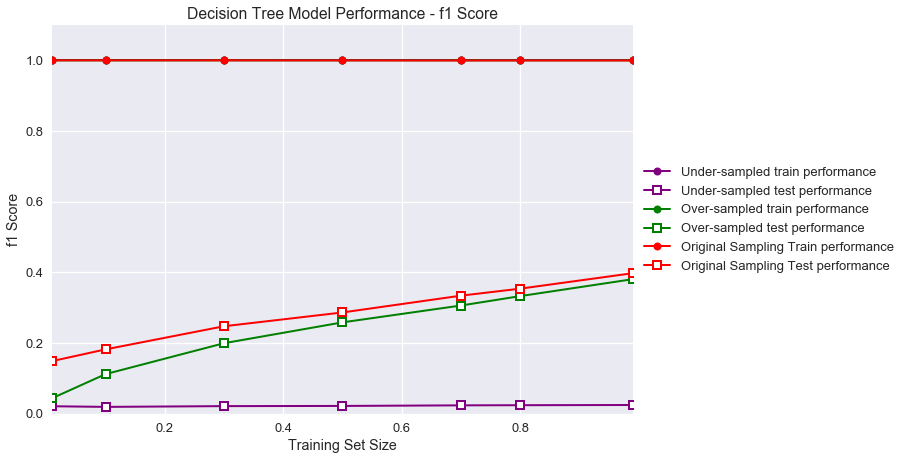

In [94]:
#decision tree, f1 score
RANDOM_STATE = 0

clf = tree.DecisionTreeClassifier(random_state = RANDOM_STATE)
training_sizes = [0.01, 0.1, 0.3, 0.5, 0.7, 0.8, .99]

df = test_size_performance(X_train, y_train, X_test, y_test, training_sizes, clf)
df2 = test_size_performance(X_train_os, y_train_os, X_test, y_test, training_sizes, clf)
df3 = test_size_performance(X_train_rus, y_train_rus, X_test, y_test, training_sizes, clf)

df['oversample_test_perf'] = df2['test_perf']
df['oversample_train_perf'] = df2['train_perf']
df['undersample_test_perf'] = df3['test_perf']
df['undersample_train_perf'] = df3['train_perf']

#plot the train and test performance of the decision trees trained on oversampled data and 
#undersampled data
sns.set()
sns.set_context('talk')

ax = df.plot(x='train_size', y='undersample_train_perf', color="purple", lw=2, ls='-', 
             marker='o', markersize=8,label='Under-sampled train performance')
ax2 = df.plot(x='train_size', y='undersample_test_perf', color="purple", lw=2, ls='-', 
              marker='s',markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Under-sampled test performance', ax = ax)
ax3 = df.plot(x='train_size', y='oversample_train_perf', color="green", lw=2, ls='-', 
              marker='o', markersize=8,label='Over-sampled train performance', ax = ax2)
ax4 = df.plot(x='train_size', y='oversample_test_perf',color="green", lw=2, ls='-', 
              marker='s',markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Over-sampled test performance',ax = ax3)
ax5 = df.plot(x='train_size', y='train_perf', color="red", lw=2, ls='-', marker='o', 
             markersize=8,label='Original Sampling Train performance', ax=ax4)
ax6 = df.plot(x='train_size', y='test_perf', color="red", lw=2, ls='-', marker='s',
              markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Original Sampling Test performance', ax = ax5,
              title = 'Decision Tree Model Performance - f1 Score')
sns.despine()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim([0,1.1])
ax.set_xlabel('Training Set Size')
ax.set_ylabel('f1 Score')

When training a decision tree classifier with recall as the performance metric, the original sampling performed slightly better than the over-sampled data, and both the original sample and the over-sample performed better than the under-sampled data. Gains in performance continued to increase with increased training set size, suggesting that the size of the data is not optimal. If it were possible to increase the data, we would expect to obtain better results. The training performance for all samples equalled 1 for all training set sizes.

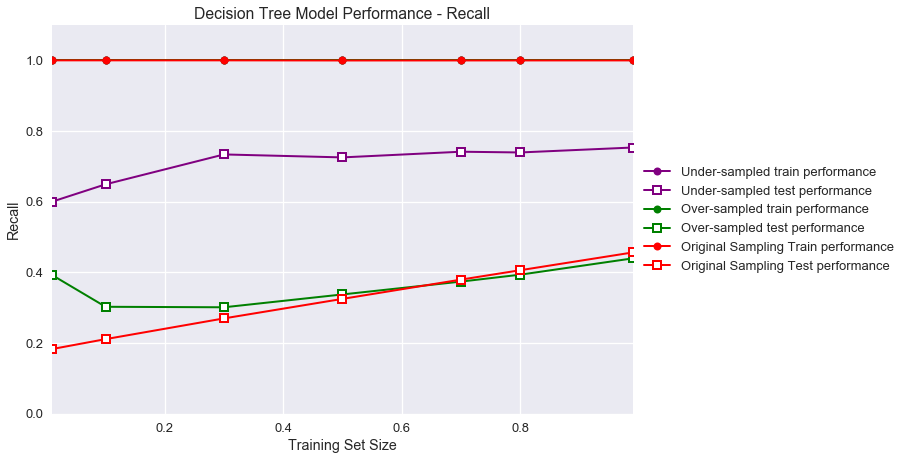

In [92]:
#decision tree, recall
clf = tree.DecisionTreeClassifier(random_state = RANDOM_STATE)
training_sizes = [0.01, 0.1, 0.3, 0.5, 0.7, 0.8, .99]

df = test_size_performance(X_train, y_train, X_test, y_test, training_sizes, clf)
df2 = test_size_performance(X_train_os, y_train_os, X_test, y_test, training_sizes, clf)
df3 = test_size_performance(X_train_rus, y_train_rus, X_test, y_test, training_sizes, clf)

df['oversample_test_perf'] = df2['test_perf']
df['oversample_train_perf'] = df2['train_perf']
df['undersample_test_perf'] = df3['test_perf']
df['undersample_train_perf'] = df3['train_perf']

#plot the train and test performance of the decision trees trained on oversampled data and 
#undersampled data
sns.set()
sns.set_context('talk')

ax = df.plot(x='train_size', y='undersample_train_perf', color="purple", lw=2, ls='-', 
             marker='o', markersize=8,label='Under-sampled train performance')
ax2 = df.plot(x='train_size', y='undersample_test_perf', color="purple", lw=2, ls='-', 
              marker='s',markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Under-sampled test performance', ax = ax)
ax3 = df.plot(x='train_size', y='oversample_train_perf', color="green", lw=2, ls='-', 
              marker='o', markersize=8,label='Over-sampled train performance', ax = ax2)
ax4 = df.plot(x='train_size', y='oversample_test_perf',color="green", lw=2, ls='-', 
              marker='s',markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Over-sampled test performance',ax = ax3)
ax5 = df.plot(x='train_size', y='train_perf', color="red", lw=2, ls='-', marker='o', 
             markersize=8,label='Original Sampling Train performance', ax=ax4)
ax6 = df.plot(x='train_size', y='test_perf', color="red", lw=2, ls='-', marker='s',
              markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Original Sampling Test performance', ax = ax5,
              title = 'Decision Tree Model Performance - Recall')
sns.despine()
sns.despine()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim([0,1.1])
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Recall')

When training a decision tree classifier with recall as the performance metric, the under-sampled data performed better than the over-sampled data and the original sample. Gains in performance plateaued with a training set size of 0.24 (.3 of the .8 training set). The training performance for all samples equalled 1 for all training set sizes. However, it is important to note that we do not reach convergence or maximum, which is a good indication that more data would benefit the model. 

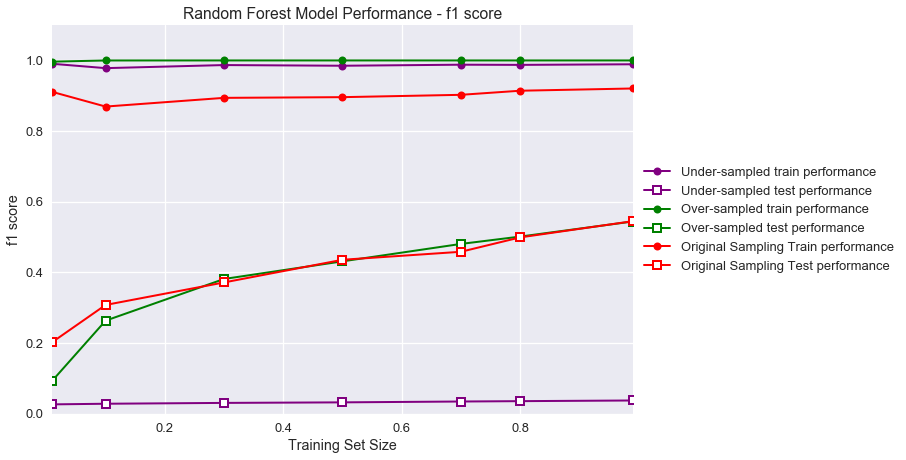

In [96]:
#random forest, f1 score with not-resampled data
clf = RandomForestClassifier(random_state = RANDOM_STATE)
training_sizes = [0.01, 0.1, 0.3, 0.5, 0.7, 0.8, .99]

df = test_size_performance(X_train, y_train, X_test, y_test, training_sizes, clf)
df2 = test_size_performance(X_train_os, y_train_os, X_test, y_test, training_sizes, clf)
df3 = test_size_performance(X_train_rus, y_train_rus, X_test, y_test, training_sizes, clf)

df['oversample_test_perf'] = df2['test_perf']
df['oversample_train_perf'] = df2['train_perf']
df['undersample_test_perf'] = df3['test_perf']
df['undersample_train_perf'] = df3['train_perf']

#plot the train and test performance of the decision trees trained on oversampled data and 
#undersampled data
sns.set()
sns.set_context('talk')

ax = df.plot(x='train_size', y='undersample_train_perf', color="purple", lw=2, ls='-', 
             marker='o', markersize=8,label='Under-sampled train performance')
ax2 = df.plot(x='train_size', y='undersample_test_perf', color="purple", lw=2, ls='-', 
              marker='s',markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Under-sampled test performance', ax = ax)
ax3 = df.plot(x='train_size', y='oversample_train_perf', color="green", lw=2, ls='-', 
              marker='o', markersize=8,label='Over-sampled train performance', ax = ax2)
ax4 = df.plot(x='train_size', y='oversample_test_perf',color="green", lw=2, ls='-', 
              marker='s',markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Over-sampled test performance',ax = ax3)
ax5 = df.plot(x='train_size', y='train_perf', color="red", lw=2, ls='-', marker='o', 
             markersize=8,label='Original Sampling Train performance', ax=ax4)
ax6 = df.plot(x='train_size', y='test_perf', color="red", lw=2, ls='-', marker='s',
              markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Original Sampling Test performance', ax = ax5,
              title = 'Random Forest Model Performance - f1 score')
sns.despine()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim([0,1.1])
ax.set_xlabel('Training Set Size')
ax.set_ylabel('f1 score')

When training a random forest classifier with f1 score as the performance metric, the original training set and the oversampled set performed similarly and both performed much better than the under sampled data. Performance continued to increase with increased training set size, suggesting that more data would benefit the model. 

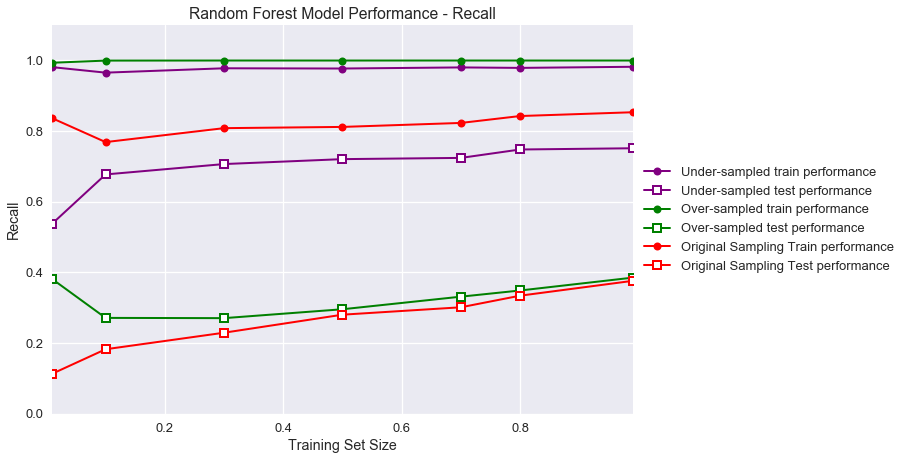

In [99]:
#random forest, recall
clf = RandomForestClassifier(random_state = RANDOM_STATE)
training_sizes = [0.01, 0.1, 0.3, 0.5, 0.7, 0.8, .99]

df = test_size_performance(X_train, y_train, X_test, y_test, training_sizes, clf)
df2 = test_size_performance(X_train_os, y_train_os, X_test, y_test, training_sizes, clf)
df3 = test_size_performance(X_train_rus, y_train_rus, X_test, y_test, training_sizes, clf)

df['oversample_test_perf'] = df2['test_perf']
df['oversample_train_perf'] = df2['train_perf']
df['undersample_test_perf'] = df3['test_perf']
df['undersample_train_perf'] = df3['train_perf']

#plot the train and test performance of the decision trees trained on oversampled data and 
#undersampled data
sns.set()
sns.set_context('talk')

ax = df.plot(x='train_size', y='undersample_train_perf', color="purple", lw=2, ls='-', 
             marker='o', markersize=8,label='Under-sampled train performance')
ax2 = df.plot(x='train_size', y='undersample_test_perf', color="purple", lw=2, ls='-', 
              marker='s',markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Under-sampled test performance', ax = ax)
ax3 = df.plot(x='train_size', y='oversample_train_perf', color="green", lw=2, ls='-', 
              marker='o', markersize=8,label='Over-sampled train performance', ax = ax2)
ax4 = df.plot(x='train_size', y='oversample_test_perf',color="green", lw=2, ls='-', 
              marker='s',markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Over-sampled test performance',ax = ax3)
ax5 = df.plot(x='train_size', y='train_perf', color="red", lw=2, ls='-', marker='o', 
             markersize=8,label='Original Sampling Train performance', ax=ax4)
ax6 = df.plot(x='train_size', y='test_perf', color="red", lw=2, ls='-', marker='s',
              markerfacecolor="white", markeredgewidth=2,markersize=8,
              label='Original Sampling Test performance', ax = ax5,
              title = 'Random Forest Model Performance - Recall')
sns.despine()
sns.despine()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim([0,1.1])
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Recall')

When training a random forest classifier with recall as the performance metric, the undersampled data performed better than the oversampled data and the original sample. Gains in performance plateaued with a training set size of 0.64 (.8 of the .8 training set). However, as with the previous iterations, it is important to note that we do not reach convergence or maximum, which is a good indication that more data would benefit the model. 

## Grid Searches

Next, I wanted to tune the hyperparameters of the models to prevent the models from overfitting the data, which is a known weakness of decision trees. I used the grid search function sci-kit learn in order to cross validate the max_depth and min_samples_leaf of the decision tree. For the random forest classifier, I used the same grid search function to cross validate the n_estimators and max_features.

I started by tuning a decision tree using recall as the performance metric. I used the undersampled data and chose a training set size of 0.2 because performance of the model plateaued at that size.

### Decision tree: 
* #### performance metric = recall, sample = under-sampling, training set size = 0.2
* #### tuning max_depth and min_samples_split

In [33]:
#Grid search: decision tree, recall, rus with train size of .2, max depth and min samples split

#redo train/test split with reduced training size 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8,
                                                    #random_state=RANDOM_STATE)

#undersample data using random under sampler 
#from imblearn.under_sampling import RandomUnderSampler 
#rus = RandomUnderSampler(random_state=0)
#X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

#from collections import Counter
#print ('Distribution of class labels before resampling {}'.format(Counter(y_train)))
#print ('Distribution of class labels after resampling {}'.format(Counter(y_train_rus)))

#Grid search - rus, recall, random forest 
clf = fit_model(X_train_rus, y_train_rus)
print('')
print('Best parameters: ',clf.best_params_)

df = pd.DataFrame(clf.cv_results_)


Best parameters:  {'max_depth': 4, 'min_samples_split': 2}


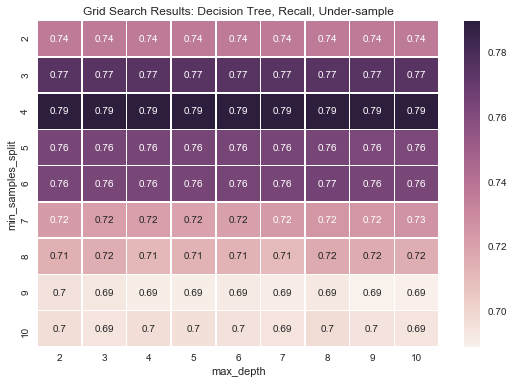

In [35]:
prange = range(2,11)

scores = df['mean_test_score'].values.reshape(len(prange),len(prange))
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(scores, annot=True, linewidths=.5, ax=ax, xticklabels=prange, yticklabels=prange)
sns.plt.xlabel('max_depth')
sns.plt.ylabel('min_samples_split')
sns.plt.title('Grid Search Results: Decision Tree, Recall, Under-sample')

#### Decision tree tuned with best parameters from grid search: max_depth=4, min_samples_split=2

In [36]:
clf = tree.DecisionTreeClassifier(max_depth=4, min_samples_split=2, random_state=RANDOM_STATE)
print_scores(X_train_rus, y_train_rus, X_test, y_test, clf, X)

Training: 
Confusion mattrix: 
 [[ 972  463]
 [ 296 1139]] 

Testing:
Confusion mattrix: 
 [[820838 365779]
 [  1333   4483]] 

recall:  0.770804676754
precision:  0.0121076426963
f1 score is:  0.0238407989832
AUC is:  0.731275522395


In [41]:
df2={'features':X.columns, 'feature_importances':clf.feature_importances_}
df2=pd.DataFrame(df2)
df2=df2.sort_values(by='feature_importances', ascending=False)
df2=df2[['features','feature_importances']]

cm = sns.light_palette("green", as_cmap=True)

df2=df2[df2.feature_importances>0]
df2 = df2.style.background_gradient(cmap=cm)
print('Features contributing to model:')
df2

Features contributing to model:


Even after adjusting the parameters based on the results of the grid search, the model did not perform well. 

Next, I tried the random forest classifier. I used the undersampled data with a training size of .64.

### Random Forest Classifier: 
* #### performance metric = recall, sample = under-sampling, training set size = 0.64
* #### tuning n_estimators and max_features

In [43]:
#Grid search - random forest, recall, rus with test size of .36

#redo train/test split with reduced training size 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.36,
                                                    random_state=RANDOM_STATE)

#undersample data using random under sampler 
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

#from collections import Counter
#print ('Distribution of class labels before resampling {}'.format(Counter(y_train)))
#print ('Distribution of class labels after resampling {}'.format(Counter(y_train_rus)))

#Grid search - rus, recall, random forest 
clf = fit_model(X_train_rus, y_train_rus)
print("Best parameters: ",clf.best_params_)

df = pd.DataFrame(clf.cv_results_)

Best parameters:  {'max_features': 2, 'n_estimators': 25}


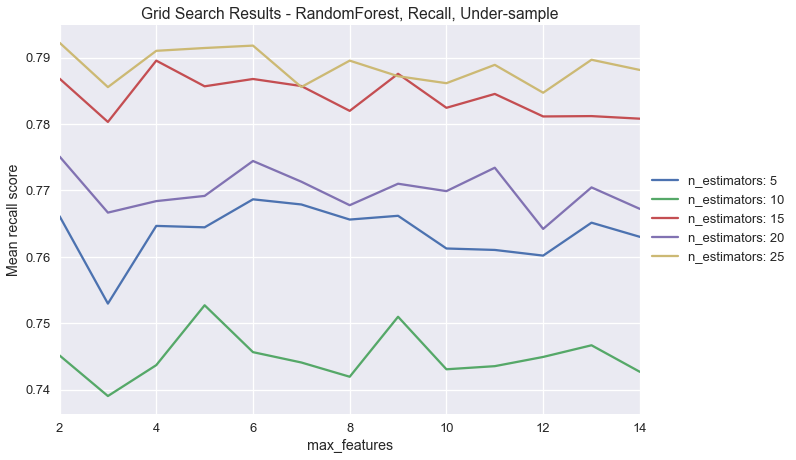

In [46]:
#plot grid search test results

plt.figure()
sns.set_context('talk')
ax = df[df.param_n_estimators==5].plot(x='param_max_features',y='mean_test_score',
                                       label='n_estimators: 5')
ax2 = df[df.param_n_estimators==10].plot(x='param_max_features',y='mean_test_score',
                                       label='n_estimators: 10', ax=ax)
ax3 = df[df.param_n_estimators==15].plot(x='param_max_features',y='mean_test_score',
                                       label='n_estimators: 15', ax = ax2)
ax4 = df[df.param_n_estimators==20].plot(x='param_max_features',y='mean_test_score',
                                       label='n_estimators: 20', ax = ax3)
ax5 = df[df.param_n_estimators==25].plot(x='param_max_features',y='mean_test_score',
                                       label='n_estimators: 25', ax = ax4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('max_features')
plt.ylabel('Mean recall score')
plt.title('Grid Search Results - RandomForest, Recall, Under-sample')
plt.show()

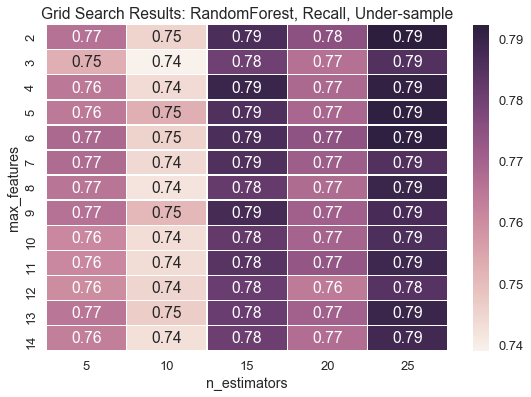

In [47]:
#draw a heat map of grid search results
ne_range = [5,10,15,20,25]
mf_range = range(2,15)

scores = df['mean_test_score'].values.reshape(len(mf_range),len(ne_range))

f, ax = plt.subplots(figsize=(9, 6))
sns.set_context('talk')
sns.heatmap(scores, annot=True, linewidths=.5,ax=ax,xticklabels=ne_range, yticklabels=mf_range)
sns.plt.xlabel('n_estimators')
sns.plt.ylabel('max_features')
sns.plt.title('Grid Search Results: RandomForest, Recall, Under-sample')

#### Random Forest Classifier tuned with best parameters from grid search: max_features=2 and n_estimators=25

In [49]:
clf = RandomForestClassifier(max_features= 2, n_estimators= 25, random_state=RANDOM_STATE)
print_scores(X_train_rus, y_train_rus, X_test, y_test, clf, X)

Training: 
Confusion mattrix: 
 [[4668    8]
 [   6 4670]] 

Testing:
Confusion mattrix: 
 [[416449 117571]
 [   519   2056]] 

recall:  0.798446601942
precision:  0.0171867554983
f1 score is:  0.0336492037774
AUC is:  0.789142217865


In [50]:
df2={'features':X.columns, 'feature_importances':clf.feature_importances_}
df2=pd.DataFrame(df2)
df2=df2.sort_values(by='feature_importances', ascending=False)
df2=df2[['features','feature_importances']]

cm = sns.light_palette("green", as_cmap=True)

df2=df2[df2.feature_importances>0]
df2 = df2.style.background_gradient(cmap=cm)
print('Features contributing to model:')
df2

Features contributing to model:


While the grid search returned optimal parameters of max_features = 2 and n_estimators = 25, the performance of the model with n_estimators = 15 was very close to n_estimators = 25. I decided to test to see if the simpler model would perform as well.

#### Random Forest Classifier tuned with max_features = 2 and n_estimators = 15

In [51]:
clf = RandomForestClassifier(max_features= 2, n_estimators= 15, random_state=RANDOM_STATE)
print_scores(X_train_rus, y_train_rus, X_test, y_test, clf, X)

Training: 
Confusion mattrix: 
 [[4656   20]
 [  26 4650]] 

Testing:
Confusion mattrix: 
 [[413882 120138]
 [   541   2034]] 

recall:  0.789902912621
precision:  0.0166486592673
f1 score is:  0.0326100026454
AUC is:  0.78246690517


In [52]:
df2={'features':X.columns, 'feature_importances':clf.feature_importances_}
df2=pd.DataFrame(df2)
df2=df2.sort_values(by='feature_importances', ascending=False)
df2=df2[['features','feature_importances']]

cm = sns.light_palette("green", as_cmap=True)

df2=df2[df2.feature_importances>0]
df2 = df2.style.background_gradient(cmap=cm)
print('Features contributing to model:')
df2

Features contributing to model:


The random forest classifier performed better than the decision tree, but the model is still producing many false positives. To see if that number could be reduced, I decided to use f1 score as the performance metric for a new grid search.

Because the original, not-resampled training data performed as well as the oversampled data, I chose to use the original training set for the grid search. In order to reduce the time required to run the grid search, I used a smaller range of parameters.

### Random Forest Classifier
* #### performance metric = f1 score, sample = original sample, training size = 0.8
* #### tuning n_estimators and max_features

In [ ]:
#Grid search - f1 score, randomforest tree

#redo train/test split with reduced training size 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state=RANDOM_STATE)
clf = fit_model(X_train, y_train)
print(clf.best_params_)

df = pd.DataFrame(clf.cv_results_)

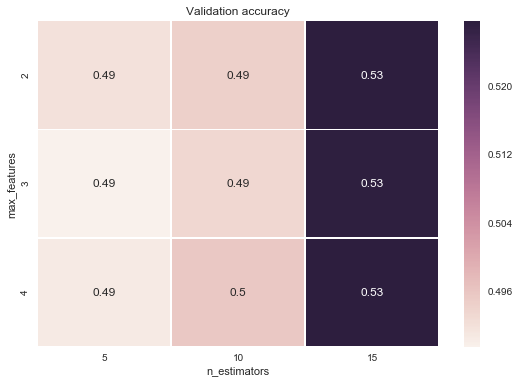

In [111]:
#draw a heat map of grid search results
ne_range2 = [5,10,15]
mf_range2 = range(2,5)

#save previous gs results in a distinct dataframe 
df_gs = df
scores2 = df_gs['mean_test_score'].values.reshape(len(mf_range2),len(ne_range2))

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(scores2, annot=True, linewidths=.5,ax=ax,xticklabels=ne_range2, 
            yticklabels=mf_range2)
sns.plt.xlabel('n_estimators')
sns.plt.ylabel('max_features')
sns.plt.title('Original Sample - Random Forest - f1 score')

#### Random Forest Classifier  tuned with best parameters from grid search: max_features = 2 and n_estimators = 15

In [112]:
clf = RandomForestClassifier(max_features=2, n_estimators=15, random_state=RANDOM_STATE)
print_scores(X_train, y_train, X_test, y_test, clf, X)

Training: 
Confusion mattrix: 
 [[1186609       3]
 [    413    5407]] 

Testing:
Confusion mattrix: 
 [[296670      8]
 [   840    591]] 

recall:  0.412997903564
precision:  0.986644407346
f1 score is:  0.582266009852
AUC is:  0.706485469151

Index(['beat', 'community_area', 'year', 'latitude', 'longitude', 'hour',
       'month', 'day_of_week', 'street', 'auto', 'apartment', 'alley', 'house',
       'others'],
      dtype='object')
[ 0.09080949  0.04484309  0.07033616  0.20635193  0.2036957   0.09302036
  0.07188539  0.05297327  0.00753004  0.09426068  0.00422183  0.00783427
  0.04850996  0.00372783]


In [ ]:
df2={'features':X.columns, 'feature_importances':clf.feature_importances_}
df2=pd.DataFrame(df2)
df2=df2.sort_values(by='feature_importances', ascending=False)
df2=df2[['features','feature_importances']]

cm = sns.light_palette("green", as_cmap=True)

df2 = df2.style.background_gradient(cmap=cm)
df2

While there were much fewer false positives when using the f1 score as the performance metric, there was a huge loss in homicide accuracy. I decided that the increase in precision was not worth the loss of recall.

Next, I returned to using recall as the performance metric and ran another grid search, this time tuning max_depth in addition to n_estimators and max_features.

### Random Forest Classifier:
* #### performance metric = recall, sample = under-sample, training size = 0.64
* #### tuning max_depth, n_estimators, and max_features

In [55]:
#Grid search - rus, recall, random forest - max features, n estimators, max depth

#redo train/test split with reduced training size 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.36,
                                                    random_state=RANDOM_STATE)

#undersample data using random under sampler 
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

#from collections import Counter
#print ('Distribution of class labels before resampling {}'.format(Counter(y_train)))
#print ('Distribution of class labels after resampling {}'.format(Counter(y_train_rus)))

clf = fit_model(X_train_rus, y_train_rus)
print("Best parameters: ",clf.best_params_)

df = pd.DataFrame(clf.cv_results_)

Best parameters:  {'max_depth': 2, 'max_features': 6, 'n_estimators': 10}


####                       Grid Search Results - Random Forest with recall as performance metric

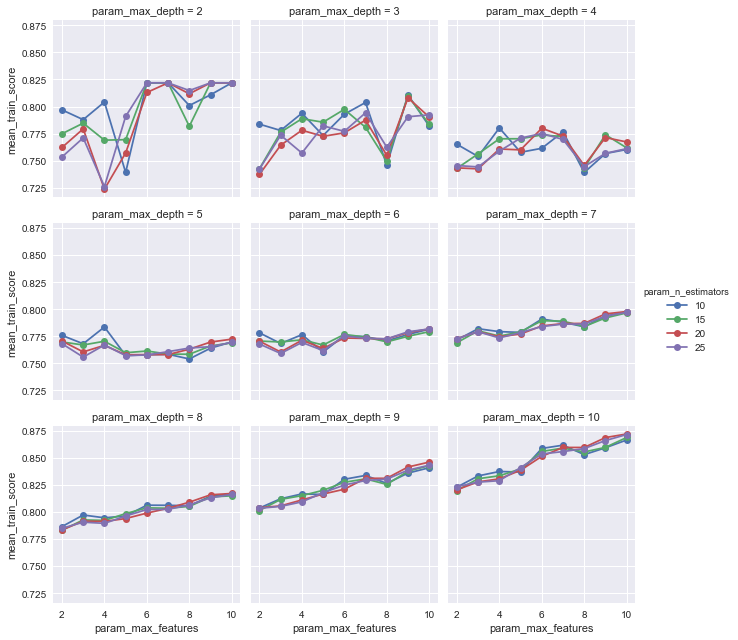

In [20]:
g = sns.FacetGrid(df, col="param_max_depth", hue="param_n_estimators", col_wrap=3)
g.map(plt.plot, "param_max_features", "mean_train_score", marker='o') #alpha=.7)
g.add_legend();

The grid search returned the following set of best parameters: max_depth=2, max_features=6, n_estimators=10. However, when you plot the results of the search, it appears that the feature set of max_depth=10, max_features=10, and n_estimators=20 performed better. I decided to run the model twice, once tuned with each set of parameters. 

From here on out, **Model 1** will refer to the model tuned with the best parameters as returned by the grid search. **Model 2** will refer to the model tuned with the best parameters as identified by visually inspecting the results of the grid search.

* ### Model 1: max_depth=2, max_features=6, n_estimators=10
* ### Model 2: max_depth=10, max_features=10, n_estimators=20

### Random Forest Classifier:

Model 1: max_depth = 2, max_features= 6, n_estimators= 10
Model 2: max_depth = 10, max_features= 10, n_estimators= 20


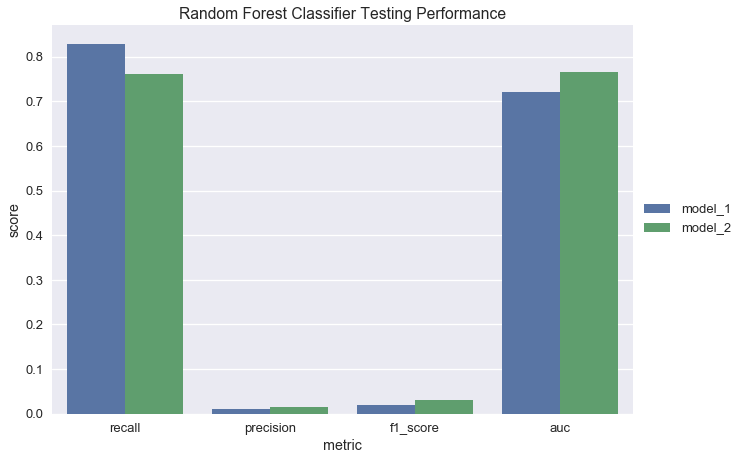

In [20]:
clf = RandomForestClassifier(max_depth = 2, max_features= 6, n_estimators= 10, random_state=RANDOM_STATE)
clf = clf.fit(X_train_rus, y_train_rus)
clf2 = RandomForestClassifier(max_depth = 10, max_features= 10, n_estimators= 20, random_state=RANDOM_STATE)
clf2 = clf2.fit(X_train_rus, y_train_rus)
  
y_pred = clf.predict(X_test)
y2_pred = clf2.predict(X_test)



results = {'model':['model_1','model_1','model_1','model_1','model_2','model_2','model_2','model_2'],
           'metric': ['recall', 'precision','f1_score','auc','recall', 'precision','f1_score','auc'],
          'score': [recall_score(y_test, y_pred),precision_score(y_test, y_pred),f1_score(y_test, y_pred),
                    roc_auc_score(y_test, y_pred),recall_score(y_test, y2_pred), precision_score(y_test, y2_pred),
                    f1_score(y_test, y2_pred),roc_auc_score(y_test, y2_pred)]}
    
results = pd.DataFrame(results)
sns.set(font_scale=1.5)
sns.set_context('talk')
ax = sns.barplot(x='metric', y='score',hue='model', data=results)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Random Forest Classifier Testing Performance')
ax.set_ylabel('score')

print('Model 1: max_depth = 2, max_features= 6, n_estimators= 10')
print('Model 2: max_depth = 10, max_features= 10, n_estimators= 20')

In [21]:
df2={'features':X.columns, 'model_1_feature_importances':clf.feature_importances_,
    'model_2_feature_importances':clf2.feature_importances_}
df2=pd.DataFrame(df2)
df2=df2[['features','model_1_feature_importances', 'model_2_feature_importances']]

cm = sns.light_palette("green", as_cmap=True)

df2 = df2.style.background_gradient(cmap=cm)

print('Model 1: max_depth = 2, max_features= 6, n_estimators= 10')
print('Model 2: max_depth = 10, max_features= 10, n_estimators= 20')
print('Features contributing to models:')
df2

Model 1: max_depth = 2, max_features= 6, n_estimators= 10
Model 2: max_depth = 10, max_features= 10, n_estimators= 20
Features contributing to models:


The two models performed similarly, but **Model 1**, the model tuned with the best parameters as defined by the grid search cross validation, did yield a slightly higher recall score, which is the metric of interest. While both models produce a large number of false positives, and thus very low precision and f1 scores, the goal of the models is to identify all homicides, so this type of error is acceptable. If a crime were to be reported with limited information, there would be a much greater cost to missing a homicide than to arriving at a scene prepared for a homicide only to find a less significant crime.

Interestingly, the location description of 'others,' representing all but the top 5 locations where homicides were most likely to occur, is the most important feature for both models. This result is interesting because it shows that you can predict if a crime is not a homicide with by only knowing if it did not occur in the street, auto, apartment, alley, or house. However, this is possibly problematic because the location category in which homicides and crimes in general are most frequently occur is 'street.' So if the model is mostly classifying homicides based on not having a location description of 'others', any crime that occurs in a street is susceptible to being misclassified as a homicide.

However, when comparing these two models, model 1 relies almost completely on the feature 'others', while model 2 places relatively higher importance on other features describing the location (such as longitude and beat) and time (such as hour and month). Due to these differences, I would prefer to use **Model 2** since it uses a wider range of features and is not as reliant on the 'others' feature. 

## Summary and Conclusions

In conclusion, when compared to all other crimes committed in Chicago between 2005 and 2016, homicides differ in several ways. While the overall crime rate peaked around 2008 and has experienced a consistent decline since, the homicide rate experienced a large increase in 2016 after having remained stable over the previous 10 years. Homicide rates have a much greater monthly variation compared to all crimes, with homicides more likely to occur in the summer months. Lastly, aside from the street where all crimes are most likely to occur, homicides and all other crimes differ in the locations in which they are most likely to occur.

I used a Random Forest Classifier in order to predict if a crime was a homicide. Homicides account for less than 1% of the data, so in order to do classify them accurately, I determined that undersampling the majority class (not-homicide) was the best way to address the imbalance in the data. However, it is important to note that when looking for the performance of the model on the validation set as a function of the training sample size, we do not reach convergence or maximum, which is a good indication that more data would benefit the model. 

After conducting a grid search cross validation to tune the parameters of the model, I identified two different parameter sets that yielded similarly high recall measures, meaning most homicides were being correctly identified. When comparing the performance of the model tuned with each set of parameters on the testing set, I chose the model that placed higher importance on a greater number of features. 

The final model was able to accurately identify about 80% of the homicides, however, it also produced a very high number of false positives. While this type of error is acceptable due to there being a much higher cost to missing a homicide than causing a false alarm, reducing the number of false alarms would still be preferable. As noted above, the lack of convergence of model performance at different training sizes suggests that more data would be useful. 